# COMP4318/5318 Assignment 2: Image Classification

### Group number: 169, SID1: 520463341, SID2: 520494068

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from tensorflow import keras
from scikeras.wrappers import KerasClassifier


## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [57]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

Exploration and Visualisation of original data:

X_train shape: (32000, 28, 28, 3)
y_train shape: (32000,)
X_test shape: (8000, 28, 28, 3)
y_test shape: (8000,)
Data type: uint8


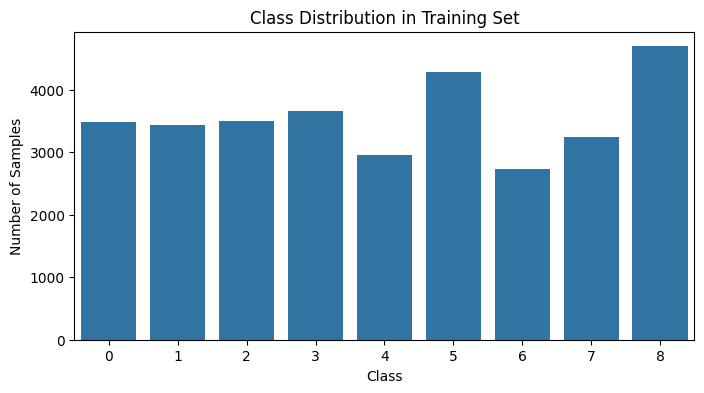

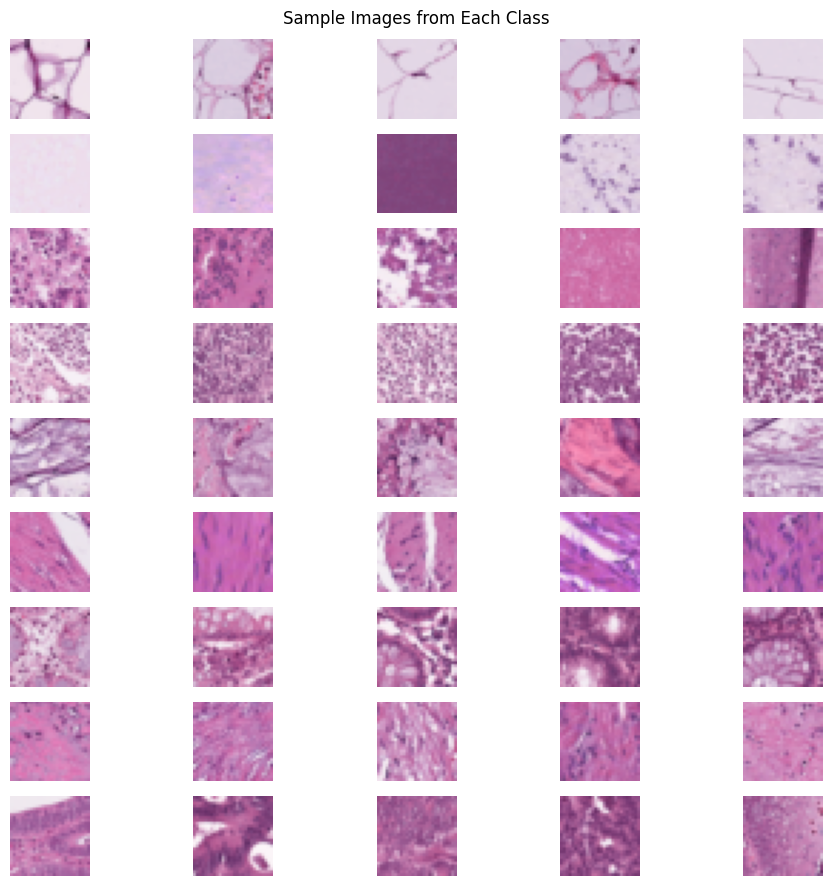

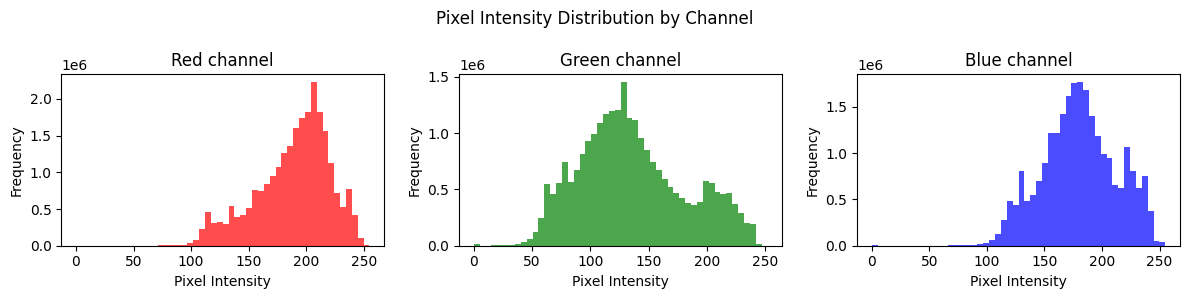

In [58]:
# Summary of shapes and types
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Data type:", X_train.dtype)

# Plot class distribution - if imbalanced, consider class weighting or oversampling
unique_classes, class_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 4))
sns.barplot(x=unique_classes, y=class_counts)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

# Plot example images from each class - if blurry, consider resizing
def plot_examples_by_class(X, y, classes=9):
    fig, axes = plt.subplots(classes, 5, figsize=(10, 9))
    for class_id in range(classes):
        class_indices = np.where(y == class_id)[0][:5]
        for i, idx in enumerate(class_indices):
            ax = axes[class_id, i]
            ax.imshow(X[idx])
            ax.axis('off')
            if i == 0:
                ax.set_ylabel(f"Class {class_id}", rotation=0, labelpad=20, va='center')
    plt.suptitle("Sample Images from Each Class")
    plt.tight_layout()
    plt.show()

plot_examples_by_class(X_train, y_train)

# Plot pixel intensity histogram for RGB channels
def plot_intensity_histograms(X):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    colors = ['red', 'green', 'blue']
    for i in range(3):
        pixel_values = X[:, :, :, i].flatten()
        axes[i].hist(pixel_values, bins=50, color=colors[i], alpha=0.7)
        axes[i].set_title(f'{colors[i].capitalize()} channel')
        axes[i].set_xlabel('Pixel Intensity')
        axes[i].set_ylabel('Frequency')
    plt.suptitle("Pixel Intensity Distribution by Channel")
    plt.tight_layout()
    plt.show()

plot_intensity_histograms(X_train)

Preprocessing:

In [59]:
def preprocess_images(X):
    """
    Normalize image pixel values to range [0, 1].
    Images are originally in uint8 format [0, 255].
    """
    X_norm = X.astype('float32') / 255.0
    return X_norm

# Did not use one-hot encoding because of sparse categorical crossentropy loss function

# Normalize images
X_train_proc = preprocess_images(X_train)
X_test_proc = preprocess_images(X_test)

# Keep original y labels (integers from 0–8)
y_train_proc = y_train
y_test_proc = y_test

# Subset the data for faster training
X_train_proc = X_train_proc[:100]
y_train_proc = y_train_proc[:100]


### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

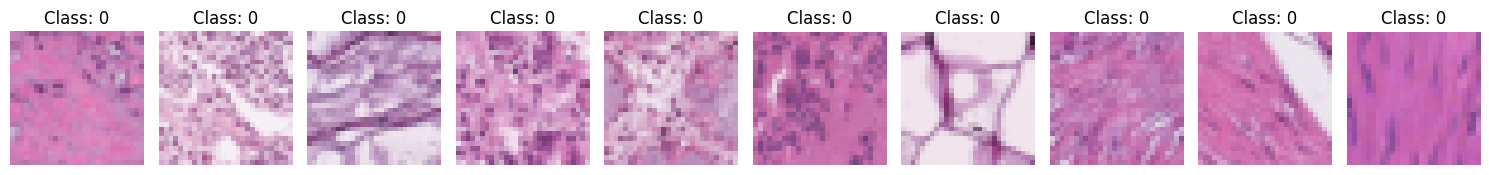

In [60]:
def show_preprocessed_examples(X_proc, y_proc, num=10):
    """
    Display a few normalized images with their class labels.
    """
    fig, axes = plt.subplots(1, num, figsize=(15, 2))
    for i in range(num):
        axes[i].imshow(X_proc[i])
        axes[i].axis('off')
        axes[i].set_title(f"Class: {np.argmax(y_proc[i])}")
    plt.tight_layout()

show_preprocessed_examples(X_train_proc, y_train_proc)

## 2. Algorithm design and setup

### k-Nearest Neighbors

In [61]:
# Use default k=3 for initial setup; will tune later
knn_model = KNeighborsClassifier(n_neighbors=3)

### Fully connected neural network

In [62]:
def build_mlp(hidden_units1=512, hidden_units2=256, learning_rate=1e-3, optimizer='adam'):
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    model = keras.models.Sequential([
        keras.layers.Input(shape=(28, 28, 3)),
        keras.layers.Flatten(),
        keras.layers.Dense(hidden_units1, activation='relu'), # relu is more efficient than tanh, modern default, avoids vanishing gradients
        keras.layers.Dropout(0.3), # Dropout helps prevent overfitting (optional)
        keras.layers.Dense(hidden_units2, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(9, activation='softmax') # Number of classes is 9
    ])
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # loss='sparse_categorical_crossentropy' for integer labels, categorical_crossentropy' for one-hot encoded labels
    return model

### Convolutional neural network

In [63]:
def build_cnn(num_filters=32, dropout_rate=0.5, learning_rate=1e-3, optimizer='adam'):
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    model = keras.Sequential([
        keras.Input(shape=(28, 28, 3)),
        keras.layers.Conv2D(num_filters, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(dropout_rate),

        keras.layers.Conv2D(num_filters * 2, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(dropout_rate),

        keras.layers.Flatten(),
        keras.layers.Dense(num_filters * 4, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(9, activation='softmax')
    ])
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

## 3. Hyperparameter tuning

### k-Nearest Neighbors

In [64]:
knn_param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan and Euclidean distances
}
X_train_flat = X_train_proc.reshape(X_train_proc.shape[0], -1)
X_test_flat = X_test_proc.reshape(X_test_proc.shape[0], -1)

start = time.time()
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=3, scoring='accuracy', n_jobs=1, verbose=3) # Set verbose=3 to keep track of runtime for each combination
knn_grid.fit(X_train_flat, y_train_proc)
end = time.time()

print("k-NN best params:", knn_grid.best_params_)
print("k-NN best score:", knn_grid.best_score_)
print("k-NN runtime:", end - start, "seconds")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END n_neighbors=1, p=1, weights=uniform;, score=0.294 total time=   0.0s
[CV 2/3] END n_neighbors=1, p=1, weights=uniform;, score=0.303 total time=   0.0s
[CV 3/3] END n_neighbors=1, p=1, weights=uniform;, score=0.212 total time=   0.0s
[CV 1/3] END n_neighbors=1, p=1, weights=distance;, score=0.294 total time=   0.0s
[CV 2/3] END n_neighbors=1, p=1, weights=distance;, score=0.303 total time=   0.0s
[CV 3/3] END n_neighbors=1, p=1, weights=distance;, score=0.212 total time=   0.0s
[CV 1/3] END n_neighbors=1, p=2, weights=uniform;, score=0.265 total time=   0.0s
[CV 2/3] END n_neighbors=1, p=2, weights=uniform;, score=0.212 total time=   0.0s
[CV 3/3] END n_neighbors=1, p=2, weights=uniform;, score=0.182 total time=   0.0s
[CV 1/3] END n_neighbors=1, p=2, weights=distance;, score=0.265 total time=   0.0s
[CV 2/3] END n_neighbors=1, p=2, weights=distance;, score=0.212 total time=   0.0s
[CV 3/3] END n_neighbors=1, p=2,

### Fully connected neural network

In [65]:
mlp_grid = {
    'model__hidden_units1': [256, 512],
    'model__hidden_units2': [128, 256],
    'model__learning_rate': [1e-2, 1e-3],
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [5],
    'batch_size': [32, 64],
}

mlp_wrapper = KerasClassifier(model=build_mlp, verbose=0)
start = time.time()
mlp_search = GridSearchCV(estimator=mlp_wrapper, param_grid=mlp_grid, cv=3, n_jobs=1, verbose=3)
mlp_search.fit(X_train_proc, y_train_proc)
end = time.time()

print("MLP best params:", mlp_search.best_params_)
print("MLP best score:", mlp_search.best_score_)
print("MLP runtime:", end - start, "seconds")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.01, optimizer=adam;, score=0.176 total time=   1.1s
[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.01, optimizer=adam;, score=0.121 total time=   1.0s
[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.01, optimizer=adam;, score=0.121 total time=   0.7s
[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.01, optimizer=rmsprop;, score=0.118 total time=   0.9s
[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.01, optimizer=rmsprop;, score=0.182 total time=   0.8s
[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_ra

### Convolutional neural network

In [66]:
cnn_grid = {
    'model__num_filters': [32, 64],
    'model__dropout_rate': [0.3, 0.5],
    'model__learning_rate': [1e-3, 5e-4],
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [10],
    'batch_size': [32, 64],
}

cnn_wrapper = KerasClassifier(model=build_cnn, verbose=0)
start = time.time()
cnn_search = GridSearchCV(estimator=cnn_wrapper, param_grid=cnn_grid, cv=3, n_jobs=1, verbose=3)
cnn_search.fit(X_train_proc, y_train_proc)
end = time.time()

print("CNN best params:", cnn_search.best_params_)
print("CNN best score:", cnn_search.best_score_)
print("CNN runtime:", end - start, "seconds")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.176 total time=   1.9s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.273 total time=   1.1s
[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.182 total time=   1.0s
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=rmsprop;, score=0.118 total time=   1.1s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=rmsprop;, score=0.182 total time=   1.3s
[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, opt

### Saving and Visualising Results and Runtimes

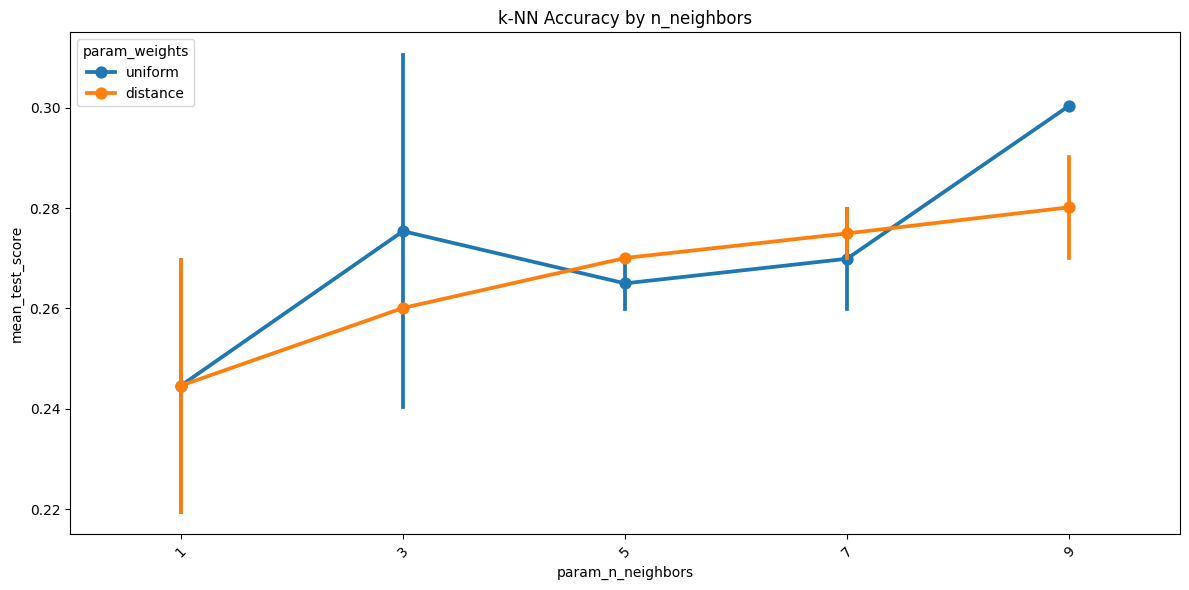

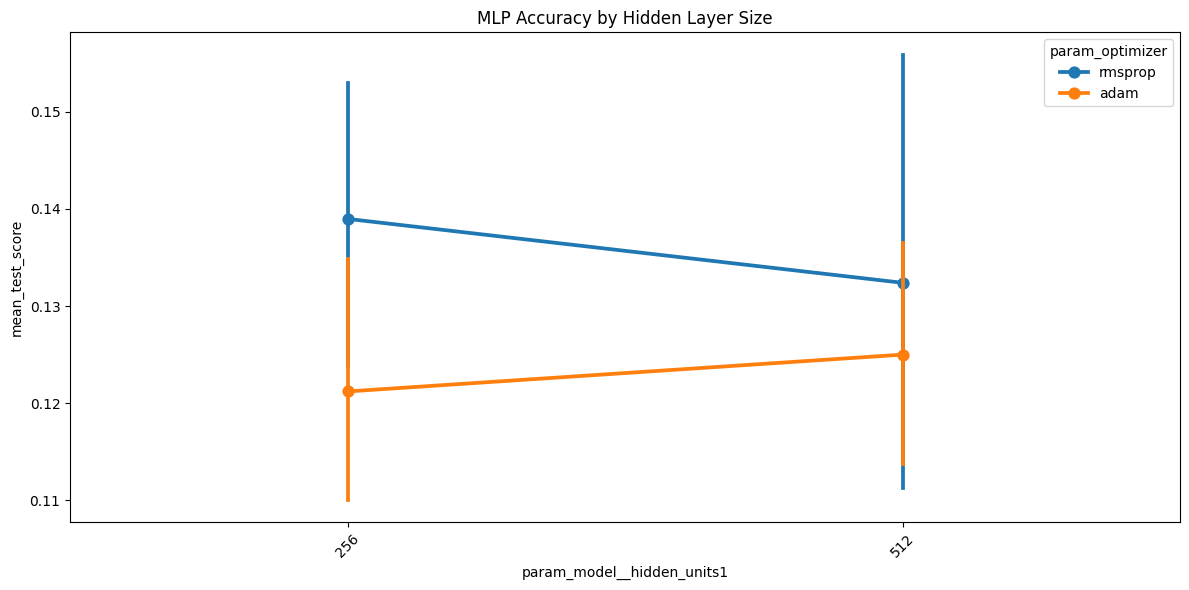

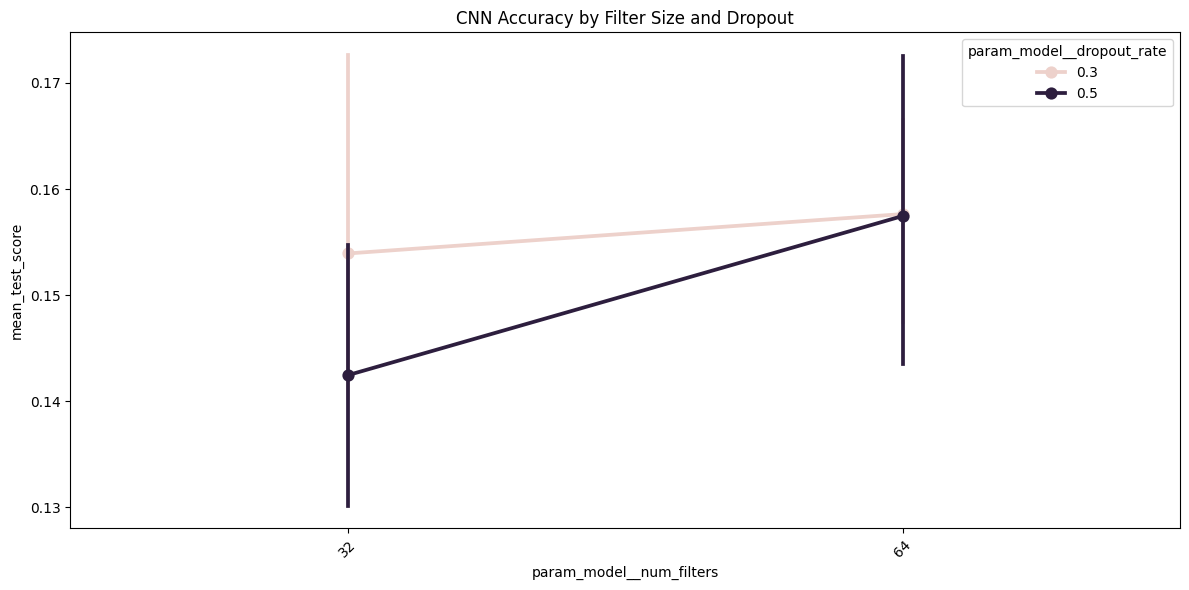

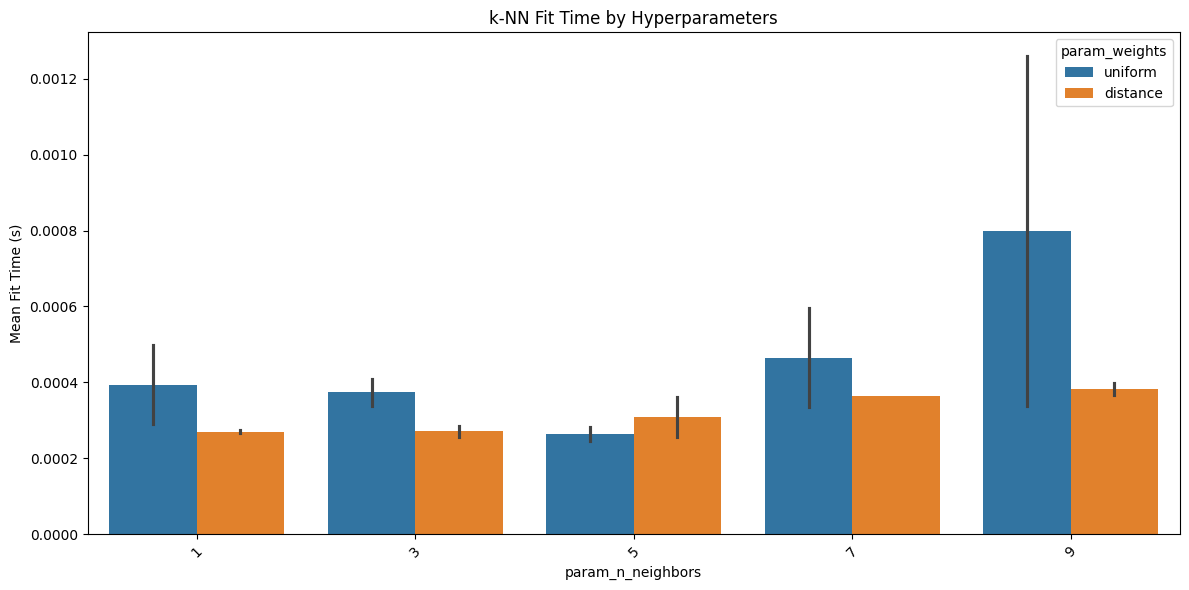

In [ ]:
def extract_gridsearch_results(grid, model_name="model"):
    """
    Extracts results from GridSearchCV and returns a DataFrame.
    Includes hyperparameters, mean score, std, fit time, and rank.
    """
    results = pd.DataFrame(grid.cv_results_)
    results["model"] = model_name
    return results

def plot_top_hyperparams(results_df, x_param, y_param="mean_test_score", hue_param=None, title=""):
    plt.figure(figsize=(12, 6))
    sns.pointplot(data=results_df.sort_values(by=y_param, ascending=False), x=x_param, y=y_param, hue=hue_param)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_fit_times(results_df, x_param, hue_param=None, title=""):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df.sort_values(by="mean_fit_time", ascending=False),
                x=x_param, y="mean_fit_time", hue=hue_param)
    plt.title(title)
    plt.ylabel("Mean Fit Time (s)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

knn_results_df = extract_gridsearch_results(knn_grid, "knn")
mlp_results_df = extract_gridsearch_results(mlp_search, "mlp")
cnn_results_df = extract_gridsearch_results(cnn_search, "cnn")

# knn_results_df.to_csv("knn_results.csv", index=False)
# mlp_results_df.to_csv("mlp_results.csv", index=False)
# cnn_results_df.to_csv("cnn_results.csv", index=False)

plot_top_hyperparams(knn_results_df, x_param="param_n_neighbors", hue_param="param_weights", title="k-NN Accuracy by n_neighbors")
plot_top_hyperparams(mlp_results_df, x_param="param_model__hidden_units1", hue_param="param_optimizer", title="MLP Accuracy by Hidden Layer Size")
plot_top_hyperparams(cnn_results_df, x_param="param_model__num_filters", hue_param="param_model__dropout_rate", title="CNN Accuracy by Filter Size and Dropout")

plot_fit_times(knn_results_df, x_param="param_n_neighbors", hue_param="param_weights", title="k-NN Fit Time by Hyperparameters")


## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### k-Nearest Neighbors

In [68]:
final_knn = KNeighborsClassifier(n_neighbors=3, p=1, weights='uniform')
final_knn.fit(X_train_flat, y_train_proc)
y_knn_pred = final_knn.predict(X_test_flat)
knn_acc = accuracy_score(y_test_proc, y_knn_pred)
print("k-NN Test Accuracy:", knn_acc)
print("k-NN Classification Report:\n", classification_report(y_test_proc, y_knn_pred))

k-NN Test Accuracy: 0.29625
k-NN Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.97      0.76       873
           1       0.07      0.01      0.02       858
           2       0.16      0.67      0.26       877
           3       0.47      0.25      0.33       914
           4       0.39      0.15      0.21       737
           5       0.39      0.18      0.24      1072
           6       0.38      0.01      0.01       682
           7       0.11      0.02      0.04       813
           8       0.25      0.32      0.28      1174

    accuracy                           0.30      8000
   macro avg       0.32      0.29      0.24      8000
weighted avg       0.32      0.30      0.25      8000



### Fully connected neural network

In [ ]:
final_mlp = build_mlp(hidden_units1=512, hidden_units2=256, learning_rate=0.01, optimizer='rmsprop')
final_mlp.fit(X_train_proc, y_train_proc, batch_size=32, epochs=5, validation_split=0.1, verbose=1)
mlp_test_loss, mlp_test_acc = final_mlp.evaluate(X_test_proc, y_test_proc, verbose=0)
print("MLP Test Accuracy:", mlp_test_acc)


Training final MLP model...
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.0874 - loss: 215.4038 - val_accuracy: 0.2000 - val_loss: 61.6678
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1141 - loss: 58.8472 - val_accuracy: 0.1000 - val_loss: 3.1969
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1086 - loss: 3.6284 - val_accuracy: 0.1000 - val_loss: 2.9631
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1927 - loss: 3.8193 - val_accuracy: 0.1000 - val_loss: 2.2057
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1787 - loss: 2.1769 - val_accuracy: 0.1000 - val_loss: 2.2091
MLP Test Accuracy: 0.1340000033378601


### Convolutional neural network

In [ ]:
final_cnn = build_cnn(num_filters=64, dropout_rate=0.3, learning_rate=0.001, optimizer='adam')
final_cnn.fit(X_train_proc, y_train_proc, batch_size=32, epochs=10, validation_split=0.1, verbose=1)
cnn_test_loss, cnn_test_acc = final_cnn.evaluate(X_test_proc, y_test_proc, verbose=0)
print("CNN Test Accuracy:", cnn_test_acc)


Training final CNN model...
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.0529 - loss: 2.3598 - val_accuracy: 0.1000 - val_loss: 2.2361
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1748 - loss: 2.1621 - val_accuracy: 0.1000 - val_loss: 2.2205
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1341 - loss: 2.1535 - val_accuracy: 0.1000 - val_loss: 2.2096
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1347 - loss: 2.1477 - val_accuracy: 0.1000 - val_loss: 2.2008
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1569 - loss: 2.1567 - val_accuracy: 0.1000 - val_loss: 2.1899
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1576 - loss: 2.1122 - val_accuracy: 0.1000 - val_loss: 2.1877
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1944 - loss: 2.0949 - val_accuracy: 0.1000 - val_loss: 2.1853
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2176 - loss: 2.0666 - val_accurac